# InPost parcel data analysis 
### Test assignment - Ernest Nadosza

This notebook calculates KPI's from the shipping event data, as defined in test assignment document:
- Average delivery time (days)
- Average package lifecycle in the system (days)
- Average pickup time from delivery point (days)
- Total number of packages



In [25]:
# Importing libs
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, min, datediff, avg, countDistinct, when

spark = SparkSession.builder.getOrCreate()
import pandas as pd

from pyspark.sql.functions import min, max
import builtins  # Import built-in functions to avoid conflicts with PySpark's min/max
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

### Load Fact and Dimension Tables

Loading the main fact table FactShippingEvent and dims (Client, Location, Date, Shipping, Statee) as defined in the data model: https://dbdiagram.io/d/Inpost-684423b55a9a94714e537852

In [26]:
fact = spark.read.parquet("/workspaces/inpost_analytics/warehouse/FactShippingEvent")
dim_shipping = spark.read.parquet("/workspaces/inpost_analytics/warehouse/DimShipping")
dim_client = spark.read.parquet("/workspaces/inpost_analytics/warehouse/DimClient")
dim_location = spark.read.parquet("/workspaces/inpost_analytics/warehouse/DimLocation")
dim_date = spark.read.parquet("/workspaces/inpost_analytics/warehouse/DimDate")

### Adding dimensions

We join the fact table with shipping, client, date and location dimension tables to enrich the event data with relevant attributes and prepare everything for calculations (filters, pivots, averages)

In [27]:
# Join fact with dim_shipping
enriched = fact.join(dim_shipping, on="shipping_id", how="left") \
    .join(dim_client, on="client_id", how="left") \
    .join(dim_date.withColumnRenamed("date", "event_date_dim"), on="date_id", how="left") \
    .join(dim_location.withColumnRenamed("location_id", "collection_location_id"), on="collection_location_id", how="left") \
    .withColumnRenamed("pays", "collection_country") \
    .withColumnRenamed("codeAgence", "collection_agency")

### Definitions and Formulas for Metrics

Below are the definitions and formulas for the four metrics calculated based on logistics events:

---

#### 1. Average Delivery Time (in days)

The time between placing the package in a locker (APM) or PUDO by the sender and putting the package in the target delivery point by the  courier.

$$
\text{Average Delivery Time} = \frac{1}{N} \sum_{i=1}^N \left( t_{\text{delivered},i} - t_{\text{sent},i} \right)
$$

---

#### 2. Average Total Lifecycle Time of the Package in the Tracking System (in days)

The time between origination of package in systeem, ie placing the package in a locker or point by the sender and its pickup by the recipient. Pickup - not delivery

$$
\text{Average Lifecycle Time} = \frac{1}{N} \sum_{i=1}^N \left( t_{\text{pickedup},i} - t_{\text{sent},i} \right)
$$

---

#### 3. Average Pickup Time from the Delivery Point by Receiver (in days)

The time between placing the package in the target  point by the courier and the pickup by the final client.

$$
\text{Average Pickup Time} = \frac{1}{N} \sum_{i=1}^N \left( t_{\text{pickedup},i} - t_{\text{delivered},i} \right)
$$

---

#### 4. Total Number of Packages

The number of unique packages processed in the system, ie, distinct shipping id's.

$$
\text{Total Packages} = N
$$

where:

- tsent — event_type = "SENT"
- tdelivered — event_type = "DELIVERED_TO_POINT"
- tpickedup — eevent_type = "PICKED_UP"
- N — number of packages (distinct shipping id's) with COMPLETE timing data 


### Calculating KPIs:

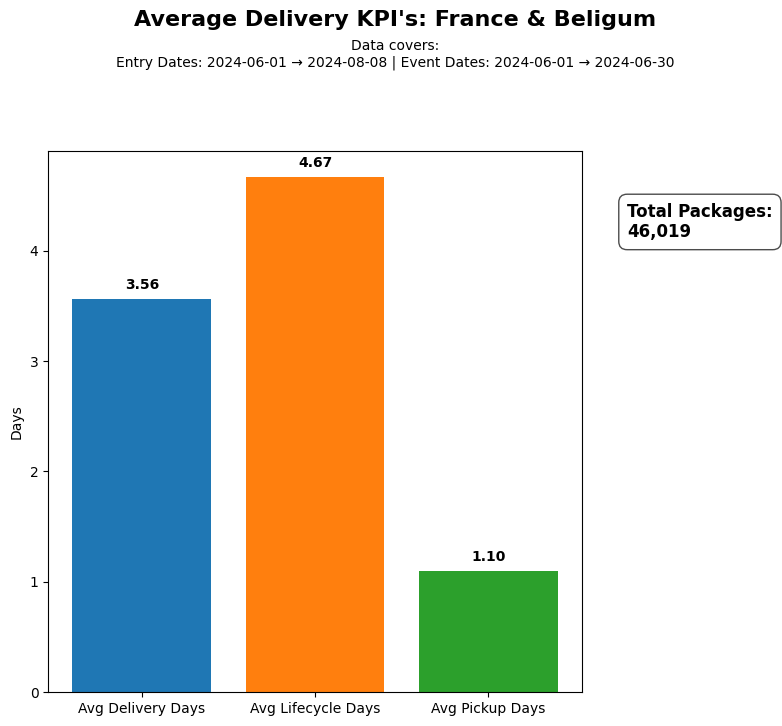

In [28]:
# Filter and labeling events for readability
filtered = enriched.filter(col("event_code").isin("PEC", "TRN", "LIV"))
labeled = filtered.withColumn(
    "event_type",
    when((col("event_code") == "PEC") & col("event_sub_code").isin("REL", "APM"), "SENT")
    .when((col("event_code") == "TRN") & col("event_sub_code").isin("REL", "APM"), "DELIVERED_TO_POINT")
    .when((col("event_code") == "LIV"), "PICKED_UP")
)

# Pivot by shipping_id
pivoted = labeled.groupBy("shipping_id").agg(
    min(when(col("event_type") == "SENT", col("event_date"))).alias("sent_time"),
    min(when(col("event_type") == "DELIVERED_TO_POINT", col("event_date"))).alias("delivered_time"),
    min(when(col("event_type") == "PICKED_UP", col("event_date"))).alias("picked_time")
)

# Calculate time deltas
with_durations = pivoted.withColumn(
    "delivery_duration", datediff("delivered_time", "sent_time")
).withColumn(
    "lifecycle_duration", datediff("picked_time", "sent_time")
).withColumn(
    "pickup_duration", datediff("picked_time", "delivered_time")
)

metrics = with_durations.agg(
    avg("delivery_duration").alias("avg_delivery_days"),
    avg("lifecycle_duration").alias("avg_lifecycle_days"),
    avg("pickup_duration").alias("avg_pickup_days"),
    countDistinct("shipping_id").alias("total_packages")
)

# Get date bounds from fact table
date_bounds = fact.select(
    min("entry_date").alias("min_entry"),
    max("entry_date").alias("max_entry"),
    min("event_date").alias("min_event"),
    max("event_date").alias("max_event")
).toPandas().iloc[0]

# Collect metrics to pandas
metrics_pd = metrics.toPandas().iloc[0]

# Prepare data for bar chart (only averages)
avg_metrics = {
    "Avg Delivery Days": metrics_pd["avg_delivery_days"],
    "Avg Lifecycle Days": metrics_pd["avg_lifecycle_days"],
    "Avg Pickup Days": metrics_pd["avg_pickup_days"]
}

# Collect metrics to pandas
metrics_pd = metrics.toPandas().iloc[0]

# Prepare data for chart 
avg_metrics = {
    "Avg Delivery Days": metrics_pd["avg_delivery_days"],
    "Avg Lifecycle Days": metrics_pd["avg_lifecycle_days"],
    "Avg Pickup Days": metrics_pd["avg_pickup_days"]
}

### Plotting the chart
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(avg_metrics.keys(), avg_metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])

fig.suptitle("Average Delivery KPI's: France & Beligum", fontsize=16, fontweight='bold', y=1.03)

#doing this to show time scope of the report
coverage_text = (
    f"Data covers:\n"
    f"Entry Dates: {date_bounds['min_entry'].date()} → {date_bounds['max_entry'].date()} | "
    f"Event Dates: {date_bounds['min_event'].date()} → {date_bounds['max_event'].date()}"
)
fig.text(0.5, 0.95, coverage_text, ha='center', fontsize=10)

# Y-axis label
ax.set_ylabel("Days")

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10, fontweight='bold')

# total packages widget
total_packages = metrics_pd["total_packages"]
ax.text(
    2.8, builtins.max(avg_metrics.values()) * 0.95,
    f"Total Packages:\n{int(total_packages):,}",
    fontsize=12, fontweight='bold', ha='left', va='top',
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5')
)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space for suptitle and subtitle
plt.show()

- **Average delivery time:** 3.56 days  
  This is below InPost's marketed KPI of 2 business days. However, this can be explained by the fact that the analysed locations are in France and Belgium, where shipping is often handled by contractors or agencies.  
  According to InPost's website, the average delivery time in these countries is around 3 business days ([source](https://inpost.pl/en/inpost-international/klient-indywidualny)).

- **Average lifecycle time:** 4.67 days  
  This is reasonable since the average pickup time (see below) is around 1 day. It suggests that the total lifecycle roughly equals delivery time plus pickup time.

- **Average pickup time:** 1.10 days  
  This fits with the relationship between delivery time and lifecycle time.

- **Total number of packages:** 46,019  
  This makes sense given that tracking data spans from June through two days in August.
